In [40]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn import model_selection, svm
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import confusion_matrix

# Loading the Data

In [2]:
df = pd.read_csv("Data/congress/NewCongressClean.csv")
np.random.seed(1000)
df['DocType_id'] = df['DocType'].map({"Public":0, "Private":1})
df

,Text,DocType,DocType_id
0,august p l protect america act sign law presid...,Private,1
1,ass recent international development leader nu...,Private,1
2,h r senate judiciary committee amendment natur...,Private,1
3,relies comprehensive set data capital flow rep...,Private,1
4,provide overview role foreign investment play ...,Private,1
...,...,...,...
8741,congressional record online government publish...,Public,0
8742,mr wittman madam speaker rise today recognitio...,Public,0
8743,christensen retire extensive noteworthy career,Public,0
8744,service assistant inspector general audit,Public,0


In [43]:
doctype_id_df = pd.DataFrame({'DocType':["Public", "Private"], 'doctype_id': [0, 1]} ) 

## Data Distribution

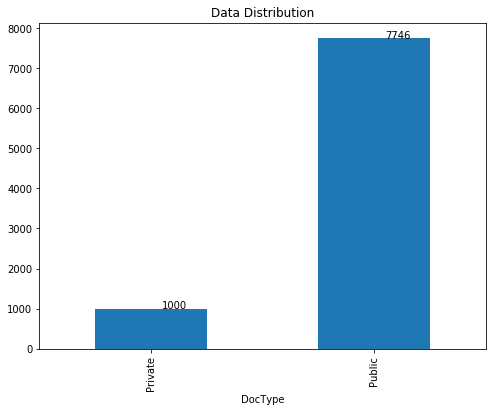

In [3]:
fig = plt.figure(figsize=(8,6))
graph = df.groupby('DocType').Text.count().plot.bar(ylim=0)

for p in graph.patches:
        graph.annotate('{:.0f}'.format(p.get_height()), (p.get_x()+0.3, p.get_height()))
graph.set_title('Data Distribution') 
plt.show()

## Train-Test Split

In [82]:
Train_X, Test_X, Train_Y, Test_Y = model_selection.train_test_split(df['Text'],df['DocType'],test_size=0.2)
print('Size of Training data: ', Train_X.shape[0])
print('Size of Test data :  ', Test_X.shape[0])

Size of Training data:  6996
Size of Test data :   1750


In [91]:
Train_counts = pd.DataFrame(Train_Y.values, columns = list('a'))
print('Train Data Distribution')
print(Train_counts['a'].value_counts())

Test_counts = pd.DataFrame(Test_Y.values, columns = list('a'))
print('\n\nTest Data Distribution')
print(Test_counts['a'].value_counts())

Train Data Distribution
Public     6183
Private     813
Name: a, dtype: int64


Test Data Distribution
Public     1563
Private     187
Name: a, dtype: int64


# Extracting Features

## TF-IDF
tf-idf (term frequency–inverse document frequency), is a numerical statistic that is intended to reflect how important a word is to a document in a collection or corpus.

* **Term Frequency tf**, is the raw count of a term in a document.
* **Inverse Document Frequency idf**, is a measure of how much information the word provides, i.e., if it's common or rare across all documents.  



### TfidfVectorizer
* **ngram_range=(min, max):** Boundary for different n-grams to be extracted. (1,1)=unigrams only, (1,2)=unigrams and bigrams, (2,2)=bigrams only.
* **max_df=<float in range[0.0, 1.0] or int default=1.0>:** Ignore terms with document frequency higher than max_df.
* **min_df=<float in range[0.0, 1.0] or int default=1.0>:** Ignore terms with document frequency lower than min_df.
* **max_features=int:** limits the features to be extracted to top max_features value
* **use_idf=bool(default=True):** Enable inverse-document-reweighting.
* **sublinear_tf=bool(default=False):** Apply sublinear tf scaling i.e. replace tf with 1+log(tf)

In [92]:
# Tfidf_vect = TfidfVectorizer(sublinear_tf=True, min_df=5, ngram_range=(3,3))
Tfidf_vect = TfidfVectorizer(ngram_range=(3,3), max_features=20000, min_df=5)
#Learn the vocabulary
Tfidf_vect.fit(df['Text'])

Train_X_Tfidf = Tfidf_vect.transform(Train_X)
print("Train Data (n_samples, n_features):", Train_X_Tfidf.shape)
Test_X_Tfidf = Tfidf_vect.transform(Test_X)
print("Test Data (Text, Features):", Test_X_Tfidf.shape)

Train Data (n_samples, n_features): (6996, 610)
Test Data (Text, Features): (1750, 610)


### Top if-idf features

In [93]:
df_public = df.loc[df["DocType"]=="Public",:]
df_private = df.loc[df["DocType"]=="Private"]
features_public = Tfidf_vect.fit_transform(df_public.Text)
features_private = Tfidf_vect.fit_transform(df_private.Text)
labels_public = df_public.DocType
labels_private = df_private.DocType
print("Features for public train data", features_public.shape)
print("Features for private train data", features_private.shape)

Features for public train data (7746, 488)
Features for private train data (1000, 93)


In [94]:
N = 20

#Public data
features_public = Tfidf_vect.fit_transform(df_public.Text)
feature_names = np.array(Tfidf_vect.get_feature_names())
tfidf_sorting = np.argsort(features_public.toarray()).flatten()[::-1]
top_public = feature_names[tfidf_sorting][:N]
# print(Tfidf_vect.vocabulary_)
print('# Public')
print(". {}".format('\n. '.join(top_public)))

# Public
. young men woman
. exclusive right respective
. exercise exclusive legislation
. exercise like authority
. export control act
. export defense article
. express sense senate
. federal aviation administration
. finance authorize meet
. first second time
. fiscal year committee
. fiscal year end
. fishery service department
. fix standard weight
. follow bill joint
. follow bill read
. follow committee authorize
. follow communication laid
. follow concurrent resolution
. follow report committee


In [95]:
#Private data
features_private = Tfidf_vect.fit_transform(df_private.Text)
feature_names = np.array(Tfidf_vect.get_feature_names())
tfidf_sorting = np.argsort(features_private.toarray()).flatten()[::-1]
top_private = feature_names[tfidf_sorting][:N]
# print(Tfidf_vect.vocabulary_)
# features_private_dict = {'Features':Tfidf_vect.vocabulary_.keys(), 'Values': Tfidf_vect.vocabulary_.values()} 
print('\n# Private')
print(". {}".format('\n. '.join(top_private)))
# features_private_dict


# Private
. year design supplement
. include united state
. free trade agreement
. full time position
. funding level related
. fy budget request
. gross domestic product
. guide one regular
. house senate appropriation
. house senate pass
. improvement reauthorization act
. information provide house
. major issue funding
. intellectual property right
. intelligence surveillance act
. international monetary fund
. introduce th congress
. issue congress include
. issue funding level
. law enforcement intelligence


# Running ML algorithms

## Naive Bayes

In [87]:
NB = MultinomialNB().fit(Train_X_Tfidf, Train_Y)

In [88]:
predicted = NB.predict(Test_X_Tfidf)
df_test = pd.DataFrame(Test_X)
df_test['Predicted'] = predicted 
df_test['Actual'] = Test_Y

### Misclassified Data

In [116]:
df_test['match'] = np.where((df_test['Predicted'] != df_test['Actual']), 'Not Match', 'Match')
df_test.loc[df_test["match"]=="Not Match",:]

,Text,Predicted,Actual,match
669,provide background international military educ...,Public,Private,Not Match
720,explains first u antidumping countervail duty ...,Public,Private,Not Match
717,government agency humanitarian organization id...,Public,Private,Not Match
465,united state respond world food program wfp ap...,Public,Private,Not Match
239,american disability act ada provide broad nond...,Public,Private,Not Match
...,...,...,...,...
745,war crime integral part bosnian war u european...,Public,Private,Not Match
22,federal budget return persistent deficit fisca...,Public,Private,Not Match
116,several reason congress might address estate t...,Public,Private,Not Match
460,provide brief discussion post employment restr...,Public,Private,Not Match


[[  44  143]
 [   6 1557]]


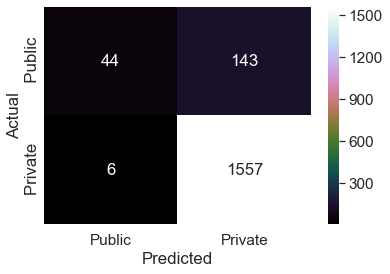

In [117]:
conf_mat = confusion_matrix(Test_Y, predicted)
print(conf_mat)

heat_map = sns.heatmap(conf_mat, xticklabels=['Public', 'Private'], yticklabels=False, cmap="cubehelix", annot=True, fmt='d')


plt.xlabel("Predicted")
plt.ylabel("Actual\nPrivate             Public")
plt.show()

## SVM

In [ ]:
SVM = svm.SVC(C=1.0, kernel='linear', degree=3, gamma='auto',random_state=0)